In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

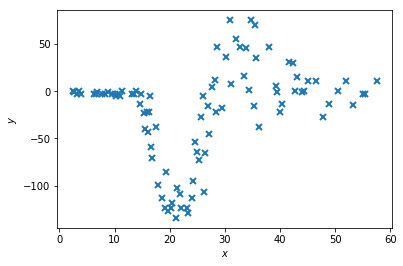

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
noisekern = gpflow.kernels.RBF(input_dim=1, ARD=True)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y[:, None], k, nonstat, noisekern)

In [4]:
m.kerns['ell0'].variance.prior = gpflow.priors.Gamma(.5,.5)
#m.kerns['ell0'].lengthscales.prior = gpflow.priors.Gamma(1.,1.)
m.kerns['ell0'].variance = 0.1
m.kerns['ell0'].variance.fixed = True
#m.kerns['ell0'].lengthscales = 1.
#m.kerns['ell0'].lengthscales.fixed = True
m.kerns['ell0'].lengthscales.prior = gpflow.priors.Gamma(1.,1.)
m.nonstat.signal_variance = 100
m.nonstat.signal_variance.fixed = True
#m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1.,1.)
m.noisekern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.noisekern.variance.prior = gpflow.priors.Gamma(.1,.1)
m.noisekern.variance = 0.05
m.noisekern.variance.fixed = True

In [5]:
m.optimize(maxiter=5000)

      fun: array([ 831.67808621])
 hess_inv: <284x284 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.88880801e-03,   1.12420257e-03,   1.63761651e-03,
         1.33239091e-03,   1.06781477e-03,   1.59902164e-03,
         8.33132545e-04,   7.86783539e-04,   7.72696814e-04,
         3.56862550e-04,   4.09346232e-06,   3.09032729e-05,
        -1.99365759e-04,   7.64738598e-04,  -2.84773789e-04,
         1.00025995e-03,   2.39991091e-04,  -5.92875938e-04,
         1.64130737e-03,   3.11708488e-04,   4.07815376e-04,
        -1.91772043e-04,  -1.31550108e-03,   3.28656103e-04,
         4.04496721e-04,   1.89358530e-03,   5.86073523e-04,
        -1.25616858e-03,   2.60185926e-04,  -3.27409155e-05,
        -2.11738972e-04,   6.21399757e-04,   9.42031919e-05,
         1.67372799e-04,   1.62249606e-04,   8.08029579e-05,
         6.84835394e-05,   3.51230754e-05,   4.77682879e-05,
         5.21769789e-05,   5.37244950e-05,   3.43111047e-05,
         1.84895813e-05,   1.76297451e-06

In [6]:
samples = m.sample(1000, verbose=True, epsilon=0.001, thin = 2, burn = 1000, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  100.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc

In [7]:
sample_df = m.get_samples_df(samples)

In [8]:
xnew = np.linspace(0, 60, 50)[:,None]
xx = (xnew - Xm) / Xv

In [9]:
mean_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
mean_n_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))

In [10]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
    mean_n, var_n = m.predict_n(xx)
    mean_n_mat[i, :] = np.exp(mean_n[:, 0]) ** 2

In [11]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat

In [12]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Sd_noise = np.sqrt(noise_var) 
    Sd_epis = np.sqrt(Vargrid)
    
    lower = Mgrid - 2. * Sd_epis
    upper = Mgrid + 2. * Sd_epis
    
    lower1 = lower - 2. * Sd_noise
    upper1 = upper + 2. * Sd_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                    color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

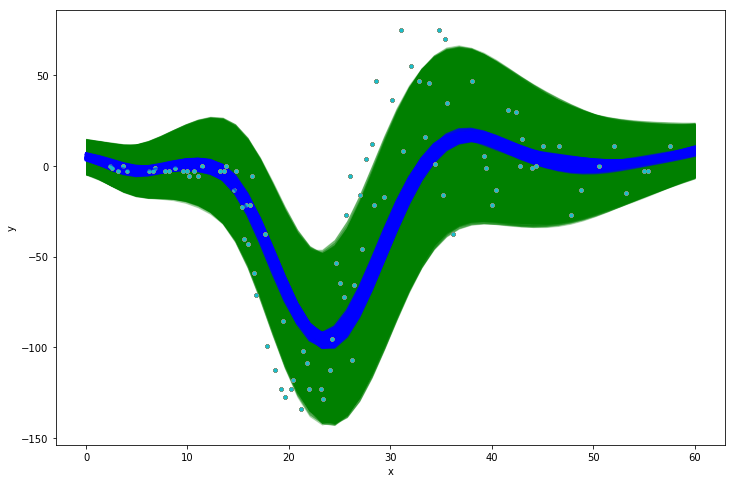

In [15]:
mini = 700
maxi = 900
plt.figure(figsize=(12, 8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var=mean_n_mat[i,:])  
#plt.plot(X_true, Y_true, 'k')